In [35]:
import torch
import numpy as np
from helper_function import NormalizeData,DomainDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from scipy.stats import qmc

In [36]:
data = np.load(r'F:\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz', allow_pickle=True)

In [37]:
data['meta']

array([['time', '28/10/2025 11:07:19'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '300'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '334'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [38]:
data=data['data'][34:,:,:]+275.15 # Converting to kelvins
data=torch.from_numpy(data).float()

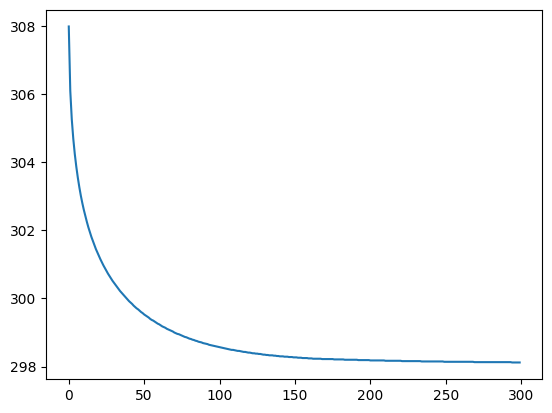

In [39]:
plt.plot(data[:,128,128])

In [40]:
T_samples,Y_samples,X_samples=data.shape
sampling_time=30.0
height=0.1 # [m] heigh of the sample
width=0.1 # [m] width of the sample 
thickness=0.005 # [m] thickness of sample


# Defining the domain in physical units
t = torch.linspace(0, T_samples/sampling_time, T_samples) # [0,T_max]
y = torch.linspace(0, height, Y_samples) # [0, H]
x = torch.linspace(0, width, X_samples) # [0, W]

# Normalizing the domain to 
t_norm,t_scale=NormalizeData(t)
y_norm,y_scale=NormalizeData(y)
x_norm,x_scale=NormalizeData(x)

t_grid, y_grid, x_grid = torch.meshgrid(t_norm, y_norm, x_norm, indexing='ij')

data_coordis = torch.stack([t_grid.reshape(-1,1),
                              y_grid.reshape(-1,1),
                                x_grid.reshape(-1,1)], dim=1).squeeze(-1)

y=data.flatten().unsqueeze(-1)

In [41]:
t_scale

tensor(10.)

In [42]:
y_scale

tensor(0.1000)

In [43]:
x_scale

tensor(0.1000)

<h1>All datapoints

In [6]:
data_coordis.size()

torch.Size([78643200, 3])

In [15]:
torch.save(data_coordis,"X_total.pt")

In [7]:
y.size()

torch.Size([78643200, 1])

In [16]:
torch.save(y,"Y_total.pt")

<h1> Collocation points

In [10]:
sampler = qmc.LatinHypercube(d=3)
X_phys_lhs = sampler.random(n=100000)
X_phys_lhs = torch.tensor(X_phys_lhs, dtype=torch.float32)

In [11]:
torch.save(X_phys_lhs, 'X_phys_lhs.pt')

In [13]:
engine = torch.quasirandom.SobolEngine(dimension=3)
X_phys_sobol = engine.draw(100000)

In [45]:
X_phys_sobol.size()

torch.Size([100000, 3])

In [14]:
torch.save(X_phys_sobol, 'X_phys_sobol.pt')

In [20]:
phys_dataset = DomainDataset(n_samples=N_samples, n_dim=3, method='random')

In [ ]:
phys_loader = DataLoader(phys_dataset, batch_size=1000, shuffle=False)

In [22]:
X_phys=next( iter( phys_loader ) )

In [23]:
X_phys

tensor([[0.3570, 0.8166, 0.8759],
        [0.1470, 0.5057, 0.3202],
        [0.9244, 0.4566, 0.6789],
        ...,
        [0.2511, 0.5193, 0.1403],
        [0.0603, 0.0612, 0.7316],
        [0.6388, 0.6204, 0.8056]])

<h1> Initial conditions

In [21]:
I_temp=data[0,:,:]
I_temp=I_temp.flatten().unsqueeze(-1)

y_grid,x_grid=torch.meshgrid(y_norm,x_norm,indexing='ij')

I_coordis=torch.stack([y_grid.reshape(-1,1),
                       x_grid.reshape(-1,1)],dim=1).squeeze(-1)

initial_time=torch.zeros(I_coordis.size(0),1)
Initial_position=torch.cat([initial_time,I_coordis],dim=1)

In [22]:
Initial_position

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0020],
        [0.0000, 0.0000, 0.0039],
        ...,
        [0.0000, 1.0000, 0.9961],
        [0.0000, 1.0000, 0.9980],
        [0.0000, 1.0000, 1.0000]])

In [23]:
torch.save(Initial_position,"X_ic.pt")

In [20]:
I_temp

tensor([[306.0600],
        [306.0800],
        [306.1000],
        ...,
        [308.6700],
        [308.6500],
        [308.6300]])

In [24]:
torch.save(I_temp,"Y_ic.pt")

<h1> Boundary conditions

In [25]:
mask_y = ((data_coordis[:, 1] == 0) | (data_coordis[:, 1] == 1)) & (data_coordis[:,0] != 0)  # y = 0 or 1 and t not 0
mask_x = ((data_coordis[:, 2] == 0) | (data_coordis[:, 2] == 1)) & (data_coordis[:,0] != 0)    # x = 0 or 1 and t not 0
mask_t = (data_coordis[:, 0] == 1) 

mask_bc = mask_y | mask_x | mask_t

coords_bc = data_coordis[mask_bc]
values_bc = y[mask_bc]

In [26]:
coords_bc

tensor([[0.0033, 0.0000, 0.0000],
        [0.0033, 0.0000, 0.0020],
        [0.0033, 0.0000, 0.0039],
        ...,
        [1.0000, 1.0000, 0.9961],
        [1.0000, 1.0000, 0.9980],
        [1.0000, 1.0000, 1.0000]])

In [28]:
torch.save(coords_bc,"X_bc.pt")

In [27]:
values_bc

tensor([[304.5700],
        [304.5000],
        [304.4700],
        ...,
        [298.1200],
        [298.1200],
        [298.1100]])

In [29]:
torch.save(values_bc,"Y_bc.pt")

In [30]:
from networks import FCN

In [31]:
Cp=700.0 # [J/(kg*K)] Specific heat of the material
q=1600.0 # [kg/m^3] Density of the material
layers= np.array([3,50,50,50,50,50,1]) # 8 hidden layers


PINN=FCN(layers,q,Cp,t_scale,y_scale,x_scale)

In [32]:
list(PINN.linears[-1].parameters())

[Parameter containing:
 tensor([[-0.1268, -0.0215, -0.3630,  0.1809,  0.1572, -0.1835,  0.1749, -0.2156,
          -0.1156,  0.3575, -0.2970, -0.0568,  0.2174,  0.1005,  0.0644,  0.2189,
           0.3860,  0.1048, -0.0399, -0.0647,  0.0111, -0.2123, -0.3158, -0.0150,
          -0.3661,  0.3547,  0.0257,  0.0044,  0.2397, -0.0285,  0.2538,  0.1872,
          -0.0900, -0.0218,  0.2172, -0.2352, -0.2720, -0.3214,  0.2480,  0.3071,
           0.1887,  0.1379, -0.2218,  0.0822,  0.0455, -0.0941,  0.1027, -0.5894,
          -0.3509, -0.0133]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

In [47]:
PINN.linears.parameters()

<generator object Module.parameters at 0x000001DE85A451C0>

In [48]:
PINN.parameters()

<generator object Module.parameters at 0x000001DE85A6A880>